Load Libraries

In [1]:
import numpy as np
import pandas as pd
import os.path as op
import spacy
nlp = spacy.load('en')

Load Data

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'))
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'cancer_projects_full.csv'))

In [27]:
kw = np.array([1,1,1])

tot = sum(kw * (kw-1))
print(1 - tot / (sum(kw) * (sum(kw) - 1)))

kw = np.array([1,0,1])

tot = sum(kw * (kw-1))
print(1 - tot / (sum(kw) * (sum(kw) - 1)))

1.0
1.0


In [16]:
# will create a dataframe with project ID, and measures of productivity for battle and journey
productivities = []

# group by id
for i, g in labeled.groupby('project_id'):
    # get the number of words total for the project text
    all_words = all_projects.loc[all_projects['id'] == i, 'text_length_words']
    
    # some (~20) projects don't have data on text body size... potential bug
    if all_words.size > 0 and all_words.values[0] > 0:
        
        # battle productivity
        kw = g.loc[g['type'] == 'battle', 'keyword'].value_counts().values
#         kw = np.append(kw, all_words.values[0])

        # compute Simpson's Index of Diversity
        #     sum n(n - 1) 
        tot = sum(kw * (kw-1))
        if sum(kw) > 0:
            battle_div = tot / (sum(kw) * (sum(kw) - 1))
        else:
            battle_div = 0.0
        
        # journey productivity
        kw = g.loc[g['type'] == 'journey', 'keyword'].value_counts().values
#         kw = np.append(kw, all_words.values[0])

        # compute Simpson's Index of Diversity
        tot = sum(kw * (kw-1))
        if sum(kw) > 0:
            journey_div = tot / (sum(kw) * (sum(kw) - 1))
        else:
            journey_div = 0.0
        
    else:
        battle_div, journey_div = 0.0, 0.0
        
    productivities.append([i, battle_div, journey_div])
    
productivities = pd.DataFrame(productivities, columns=['id', 'battle_prod', 'journey_prod'])

/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/Users/alex/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


Top projects by productivity, after looking at the text of these projects, the measure seems like an accurate representation of diversity in metaphor instantiation.

In [17]:
productivities.nlargest(10, 'battle_prod')

,id,battle_prod,journey_prod
92,416161485,1.0,0.0
132,602478402,1.0,NaN
174,841272237,1.0,0.0
178,871062846,1.0,0.0
179,871430700,1.0,0.0
181,877694775,1.0,0.0
277,1312205664,1.0,0.0
395,1796996959,1.0,0.0
430,2002629819,1.0,NaN
141,635532699,0.5,0.0


An example project:

In [30]:
all_projects.loc[all_projects['id'] == 1665364667, :]

,id,name,blurb,created,launched,deadline,goal,spotlight,staff_pick,status,...,journey_uniques,battle_salience,journey_salience,battle_productivity,journey_productivity,dominant_battle,dominant_journey,dominant_both,dominant_neither,dominant
3,1665364667,A Recipe for Hope,Our family's journey living with and fighting ...,1470688455,1473253802,1475845802,5500,True,False,1,...,0,0.007634,0.0,0.625,0.0,1,0,0,0,Battle


In [29]:
labeled.loc[labeled['project_id'] == 1665364667]

,project_id,fragment,char_location,type,keyword
43,1665364667,", humor, and heroes. But most importantly, it ...",2054.0,battle,fight
44,1665364667,70 percent of cancers can be prevented with di...,2591.0,battle,fight
45,1665364667,"ifestyle could help. For example, I came up w...",1123.0,battle,fights
46,1665364667,e. I’ve also included over 50 tasty recipes w...,2222.0,battle,fighting
47,1665364667,"goal, we need to supply the body with the nutr...",4741.0,battle,fighting
48,1665364667,vement!!! . . . Reading this has deepened my c...,5494.0,battle,fighting
49,1665364667,"d. To be honest, I just chronicled the true st...",205.0,battle,battled
50,1665364667,She never cheated nor wavered . . . ever. As ...,1665.0,battle,war


Create a copy (so as to not affect the original) and merge

In [8]:
all_projects_c = all_projects.copy(deep=True)

In [9]:
all_projects_c = all_projects_c.merge(productivities, how='left', on='id', validate='one_to_one')

It looks like our measures of diversity are highly correlated with salience:

In [10]:
np.corrcoef(all_projects_c[['battle_prod', 'journey_prod', 'battle_salience', 'journey_salience']], rowvar=False)

array([[1.        , 0.00524885, 0.99994957, 0.00394083],
       [0.00524885, 1.        , 0.00547719, 0.99979795],
       [0.99994957, 0.00547719, 1.        , 0.00417079],
       [0.00394083, 0.99979795, 0.00417079, 1.        ]])

# attempt 2

In [62]:
battle_vc = labeled.dropna().loc[labeled['type'] == 'battle', 'keyword'].value_counts()
journey_vc = labeled.dropna().loc[labeled['type'] == 'journey', 'keyword'].value_counts()

print(battle_vc)

r = 0.4

battle_freq_map = dict((sum(battle_vc) / battle_vc) ** r)
journey_freq_map = dict((sum(journey_vc) / journey_vc) ** r)

fight       73
fighting    57
battle      55
battling    27
beat        11
fought       8
battled      6
fights       4
battles      4
war          4
beating      4
enemy        2
beaten       1
beats        1
Name: keyword, dtype: int64


In [63]:
battle_freq_map

{'fight': 1.6544136524410165,
 'fighting': 1.8265152688203756,
 'battle': 1.852798427841616,
 'battling': 2.4627920537921617,
 'beat': 3.5270870248072796,
 'fought': 4.006242691001405,
 'battled': 4.494824601075255,
 'fights': 5.286268923252441,
 'battles': 5.286268923252441,
 'war': 5.286268923252441,
 'beating': 5.286268923252441,
 'enemy': 6.975273662704507,
 'beaten': 9.203928777744418,
 'beats': 9.203928777744418}

In [49]:
# will create a dataframe with project ID, and measures of productivity for battle and journey
productivities = []

# group by id
for i, g in labeled.groupby('project_id'):
    # get the number of words total for the project text
    all_words = all_projects.loc[all_projects['id'] == i, 'text_length_words']
    
    # some (~20) projects don't have data on text body size... potential bug
    if all_words.size > 0 and all_words.values[0] > 0:
        
        kw = g.loc[g['type'] == 'battle', 'keyword'].value_counts()
        s = [battle_freq_map[k] * kw[k] for k in dict(kw)]
        battle_div = sum(s)
        
        kw = g.loc[g['type'] == 'journey', 'keyword'].value_counts()
        s = [journey_freq_map[k] * kw[k] for k in dict(kw)]
        journey_div = sum(s)
        
    else:
        battle_div, journey_div = 0.0, 0.0
        
    productivities.append([i, battle_div, journey_div])
    
productivities = pd.DataFrame(productivities, columns=['id', 'battle_prod', 'journey_prod'])

In [50]:
all_projects_c = all_projects.copy(deep=True)
all_projects_c = all_projects_c.merge(productivities, how='left', on='id', validate='one_to_one')

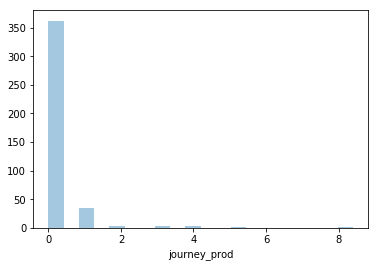

In [55]:
import seaborn as sns
sns.distplot(all_projects_c['journey_prod'], kde=False)

In [53]:
all_projects_c.loc[all_projects_c['battle_prod'] < 5].shape

(372, 50)

In [65]:
all_projects_c.nlargest(10, 'battle_prod')

,id,name,blurb,created,launched,deadline,goal,spotlight,staff_pick,status,...,journey_salience,battle_productivity,journey_productivity,dominant_battle,dominant_journey,dominant_both,dominant_neither,dominant,battle_prod,journey_prod
3,1665364667,A Recipe for Hope,Our family's journey living with and fighting ...,1470688455,1473253802,1475845802,5500,True,False,1,...,0.000000,0.625000,0.000000,1,0,0,0,Battle,23.855736,0.000000
78,238840799,THE KNOCKOUT,For our KNOCKOUT Breast Cancer Photo Shoot eve...,1396740076,1406927542,1412111542,5000,True,False,1,...,0.000000,0.500000,0.000000,1,0,0,0,Battle,17.120015,0.000000
33,1490542747,Whatever Happened to Patient 2410,The inspiring autobiography of the late Minda ...,1385095833,1409332843,1411924843,6000,True,True,1,...,0.000000,0.666667,0.000000,1,0,0,0,Battle,15.067362,0.000000
26,134281058,THE BOOK OF HEALERS HEALING: AN ODYSSEY THROUG...,"Combining narrative, poetry & interviews with ...",1380120239,1381249864,1384060320,5000,True,False,1,...,0.000000,1.000000,0.000000,1,0,0,0,Battle,14.490198,0.000000
158,8143920,Music for cancer Fighters,My mother is a cancer survivor I seen her pain...,1455843485,1484560151,1487152151,2500,False,False,0,...,0.000000,0.500000,0.000000,1,0,0,0,Battle,12.966717,0.000000
218,981149095,"""Be Here Now"" – The Andy Whitfield Story",Inspiring documentary about Andy Whitfield who...,1336147853,1339185851,1343073851,200000,True,False,1,...,0.000000,0.800000,0.000000,1,0,0,0,Battle,12.274410,0.000000
262,840125324,"The Girl Who Had a Big Adventure - Cancer, Che...","Doing video & audio versions of the book ""The ...",1349900627,1351276267,1352143867,2100,True,False,1,...,0.000000,1.000000,0.000000,1,0,0,0,Battle,11.056727,0.000000
42,481532678,Always Live Laugh Love Featured Film,Featured Film nearly completed 10 % of this fi...,1471127729,1471144844,1475032844,5000,False,False,0,...,0.000000,1.000000,0.000000,1,0,0,0,Battle,11.014259,0.000000
25,1105507467,A Tale of 2 Boobies - One Year With Cancer,"From diagnosis to surgery, chemotherapy, radia...",1411570934,1412366380,1414961980,2000,True,False,1,...,0.003178,1.000000,0.333333,0,0,1,0,Both,10.482486,3.030929
341,2049604249,How To Beat Cancer: Survivor Reflections,A podcast about cancer survivors and how they ...,1379592012,1380648565,1383240565,700,True,False,1,...,0.000000,1.000000,0.000000,1,0,0,0,Battle,10.467770,0.000000


In [66]:
labeled.loc[labeled['project_id'] == 1665364667]

,project_id,fragment,char_location,type,keyword
43,1665364667,", humor, and heroes. But most importantly, it ...",2054.0,battle,fight
44,1665364667,70 percent of cancers can be prevented with di...,2591.0,battle,fight
45,1665364667,"ifestyle could help. For example, I came up w...",1123.0,battle,fights
46,1665364667,e. I’ve also included over 50 tasty recipes w...,2222.0,battle,fighting
47,1665364667,"goal, we need to supply the body with the nutr...",4741.0,battle,fighting
48,1665364667,vement!!! . . . Reading this has deepened my c...,5494.0,battle,fighting
49,1665364667,"d. To be honest, I just chronicled the true st...",205.0,battle,battled
50,1665364667,She never cheated nor wavered . . . ever. As ...,1665.0,battle,war
